<a href="https://colab.research.google.com/github/Misheal-22/Traffic-Sign-Recognition-Model/blob/main/Traffic_Sign_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


In [2]:
!pip install opendatasets

In [3]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: misheal22
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign


100%|██████████| 612M/612M [00:01<00:00, 405MB/s]


In [4]:
DATASET_PATH = "/content/gtsrb-german-traffic-sign/train"   # adjust path

IMG_SIZE = 48   # resize all images to 48x48
images, labels = [], []

for label in os.listdir(DATASET_PATH):
    folder = os.path.join(DATASET_PATH, label)
    if not os.path.isdir(folder):
        continue
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        images.append(img)
        labels.append(int(label))

X = np.array(images) / 255.0   # normalize to [0,1]
y = np.array(labels)

# one-hot encode labels
num_classes = len(np.unique(y))
y = to_categorical(y, num_classes)

# split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (31367, 48, 48, 3) Test shape: (7842, 48, 48, 3)


DATA AUGMENTATION

In [5]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)
datagen.fit(X_train)


CUSTOM CNN MODEL

In [6]:
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = cnn_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=20
)



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


981/981 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - accuracy: 0.3529 - loss: 2.4932 - val_accuracy: 0.9328 - val_loss: 0.2334
Epoch 2/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 29s 30ms/step - accuracy: 0.8319 - loss: 0.5216 - val_accuracy: 0.9810 - val_loss: 0.0616
Epoch 3/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 28s 29ms/step - accuracy: 0.9154 - loss: 0.2700 - val_accuracy: 0.9767 - val_loss: 0.0737
Epoch 4/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 28s 29ms/step - accuracy: 0.9376 - loss: 0.2004 - val_accuracy: 0.9851 - val_loss: 0.0462
Epoch 5/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 29s 30ms/step - accuracy: 0.9492 - loss: 0.1632 - val_accuracy: 0.9936 - val_loss: 0.0235
Epoch 6/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 28s 29ms/step - accuracy: 0.9589 - loss: 0.1338 - val_accuracy: 0.9921 - val_loss: 0.0258
Epoch 7/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 28s 29ms/step - accuracy: 0.9627 - loss: 0.1255 - val_accuracy: 0.9904 - val_loss: 0.0308
Epoch 8/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 42s 30ms/step - accuracy: 0.9682 - loss: 0.1117 - val_accurac

MOBILE NETV2 TRANSFER LEARNING

In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False   # freeze base model

mobilenet_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

mobilenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 🔹 UPDATED HERE → save history for MobileNet
mobilenet_history = mobilenet_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=10
)

/tmp/ipython-input-587462405.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


981/981 ━━━━━━━━━━━━━━━━━━━━ 72s 58ms/step - accuracy: 0.3061 - loss: 2.5247 - val_accuracy: 0.5657 - val_loss: 1.3400
Epoch 2/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 31s 32ms/step - accuracy: 0.4820 - loss: 1.6114 - val_accuracy: 0.6116 - val_loss: 1.1631
Epoch 3/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - accuracy: 0.5245 - loss: 1.4457 - val_accuracy: 0.6435 - val_loss: 1.0733
Epoch 4/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 31s 32ms/step - accuracy: 0.5449 - loss: 1.3696 - val_accuracy: 0.6687 - val_loss: 1.0067
Epoch 5/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 36s 36ms/step - accuracy: 0.5648 - loss: 1.3129 - val_accuracy: 0.6891 - val_loss: 0.9284
Epoch 6/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 32s 33ms/step - accuracy: 0.5804 - loss: 1.2699 - val_accuracy: 0.6938 - val_loss: 0.9116
Epoch 7/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 30s 31ms/step - accuracy: 0.5986 - loss: 1.2344 - val_accuracy: 0.7089 - val_loss: 0.8755
Epoch 8/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 31s 32ms/step - accuracy: 0.6008 - loss: 1.2054 - val_accurac

PLOT TRAINING CURVES

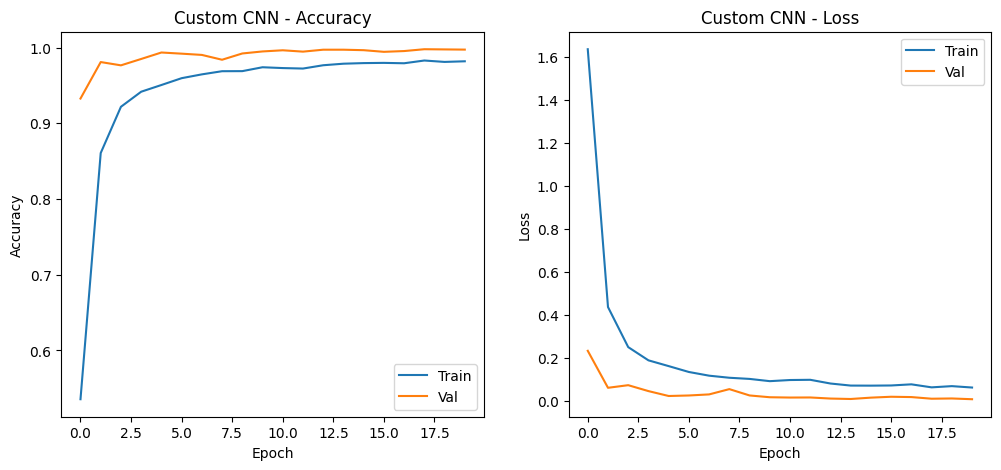

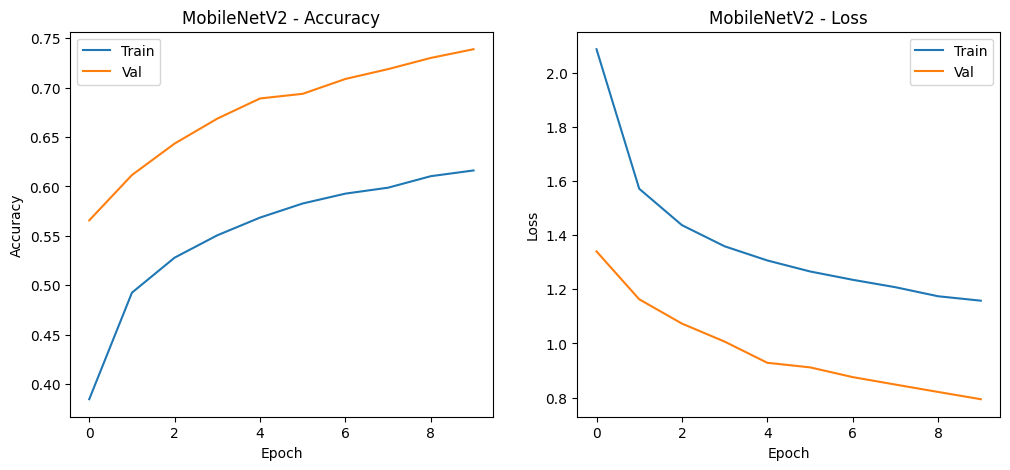

In [10]:
def plot_history(history, title="Model"):
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

# 🔹 UPDATED HERE → compare CNN vs MobileNet
plot_history(history, "Custom CNN")
plot_history(mobilenet_history, "MobileNetV2")

EVALUATION (CUSTOM CNN)

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

=== Custom CNN Results ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        42
           1       1.00      0.99      1.00       444
           2       0.99      1.00      0.99       450
           3       1.00      0.98      0.99       282
           4       1.00      1.00      1.00       396
           5       0.98      0.99      0.99       372
           6       1.00      1.00      1.00        84
           7       1.00      0.99      1.00       288
           8       0.99      1.00      0.99       282
           9       1.00      1.00      1.00       294
          10       1.00      1.00      1.00       402
          11       1.00      1.00      1.00       264
          12       1.00      1.00      1.00       420
          13       1.00      1.00      1.00       432
          14       1.00      1.00      1.00       156
          15       0.99      1.00      1.00       126
          16

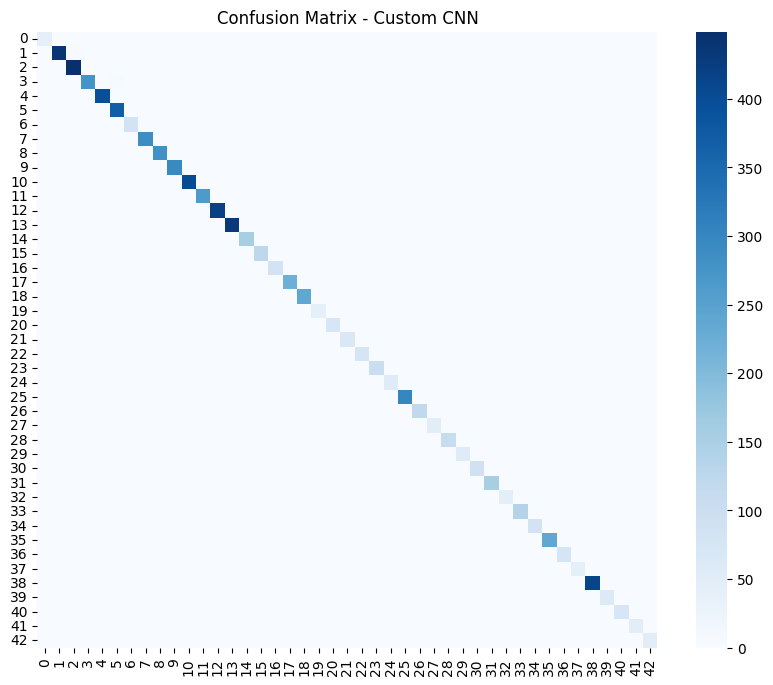

In [11]:
y_pred_cnn = np.argmax(cnn_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n=== Custom CNN Results ===")
print(classification_report(y_true, y_pred_cnn))

cm_cnn = confusion_matrix(y_true, y_pred_cnn)
plt.figure(figsize=(10,8))
sns.heatmap(cm_cnn, annot=False, cmap="Blues")
plt.title("Confusion Matrix - Custom CNN")
plt.show()

EVALUATION (MOBILENET)

246/246 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step

=== MobileNetV2 Results ===
              precision    recall  f1-score   support

           0       0.93      0.33      0.49        42
           1       0.63      0.76      0.69       444
           2       0.63      0.61      0.62       450
           3       0.67      0.49      0.57       282
           4       0.67      0.63      0.65       396
           5       0.63      0.71      0.66       372
           6       0.89      0.79      0.84        84
           7       0.76      0.72      0.74       288
           8       0.66      0.59      0.62       282
           9       0.80      0.78      0.79       294
          10       0.79      0.88      0.83       402
          11       0.54      0.72      0.62       264
          12       0.97      0.96      0.97       420
          13       0.95      0.98      0.96       432
          14       0.91      0.95      0.93       156
          15       0.89      0.95      0.92       126
         

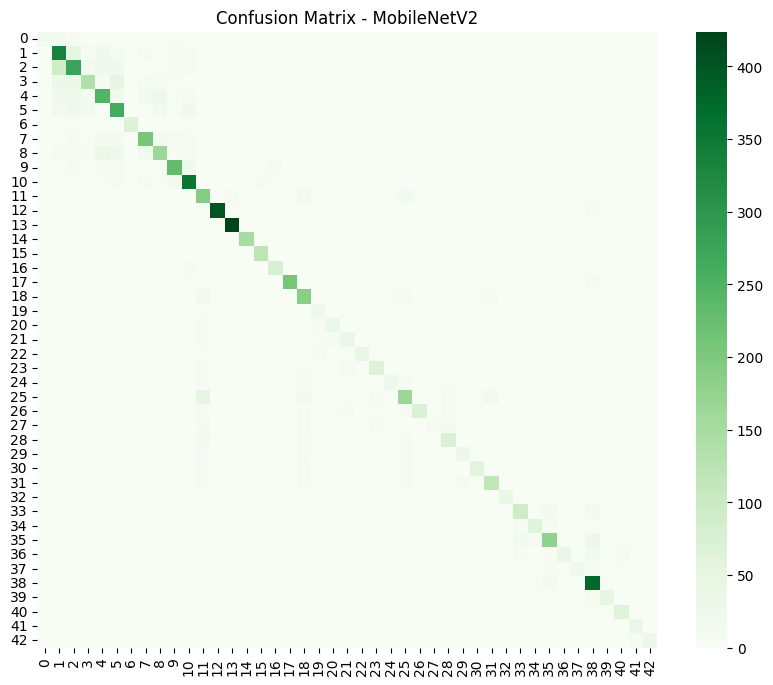

In [12]:
y_pred_mobilenet = np.argmax(mobilenet_model.predict(X_test), axis=1)

print("\n=== MobileNetV2 Results ===")
print(classification_report(y_true, y_pred_mobilenet))

cm_mobilenet = confusion_matrix(y_true, y_pred_mobilenet)
plt.figure(figsize=(10,8))
sns.heatmap(cm_mobilenet, annot=False, cmap="Greens")
plt.title("Confusion Matrix - MobileNetV2")
plt.show()


COMPARE FINAL ACCURACY

In [13]:
cnn_acc = history.history['val_accuracy'][-1]
mobilenet_acc = mobilenet_history.history['val_accuracy'][-1]

print(f"✅ Final Validation Accuracy - Custom CNN: {cnn_acc:.4f}")
print(f"✅ Final Validation Accuracy - MobileNetV2: {mobilenet_acc:.4f}")

✅ Final Validation Accuracy - Custom CNN: 0.9974
✅ Final Validation Accuracy - MobileNetV2: 0.7390
